
# Online News Popularity Classification
## -Preprocessing

### Xian Lai
xlai4@fordham.edu

=======================================================

### Data set:
This online news popularity data set comes from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/online+news+popularity). It summarizes a heterogeneous set of features about 39,644 news articles published by Mashable.com in a period of two years.

Among these features, there are:
- **58 predicitive input attributes** about the count of stop words, length of stop word, number of links, images and video on the webpage and other NLP features; 
- **2 non-predictive features** include webpage url and publish time; 
- **1 target feature** namely the times of shares in social networks (popularity).

### Task:
The task of this project is to find a model that can classify new articles into class popular or unpopular (divided by 'shares' = 1400) using those 58 predictive input features.

In [1]:
import pandas as pd
import numpy as np

import sklearn.preprocessing as prep
from sklearn.decomposition import PCA, SparsePCA, FactorAnalysis, NMF

import sys; sys.path.append('modules')
import _visual as vis

### Import data and split input and target features:

In [2]:
df = pd.read_csv("data/input_dataset/OnlineNewsPopularity.csv", skipinitialspace=True)

sr_Y = df['shares']
df_X = df.drop(['url', 'timedelta', 'shares'], axis=1) # delete non-predictive & taget features

### Target feature :
First of all let us investigate the target feature. By plotting out the histogram and scatter of target feature after removing outliers, we can see it concentrates at small values and distributed approximately normal trimmed at value 0. 

Because our task is classification, we will binarize the target feature by its median (1400). Thus the articles have more than 1400 shares are popular labeled by 1 and the ones have less or equal to 1400 shares are unpopular labeled by 0.

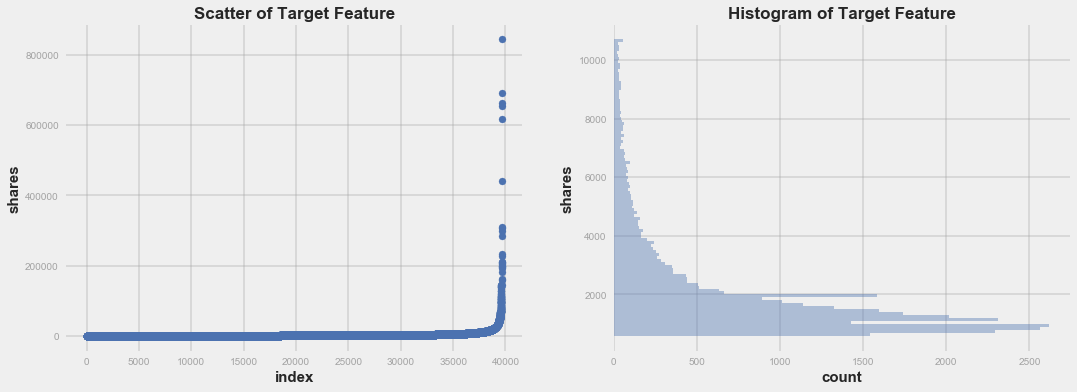


The median of target feature is: 1400.00


In [3]:
percentile_95 = np.percentile(sr_Y.values, 95)
percentile_5 = np.percentile(sr_Y.values, 5)

v = vis.Visual(1, 2, figsize=(18,6))

v.axes[0].scatter(range(len(sr_Y)), np.sort(sr_Y))
v.axes[0].set_xlabel('index', **vis.ax_font)
v.axes[0].set_ylabel('shares', **vis.ax_font)
v.axes[0].set_title('Scatter of Target Feature', **vis.fig_font)

vis.sns.distplot(sr_Y[(sr_Y>percentile_5) & (sr_Y<percentile_95)], bins=100, kde=False, ax=v.axes[1], vertical=True)
v.axes[1].set_xlabel('count', **vis.ax_font)
v.axes[1].set_ylabel('shares', **vis.ax_font)
v.axes[1].set_title('Histogram of Target Feature', **vis.fig_font)

vis.plt.show()
print('\nThe median of target feature is: %.2f' %sr_Y.median())

### Input features: 
After dropping non-predictive input features, there are 58 input features remaining. 

  **Data types:** All the input features have numerical values, but by counting the unique values, we can tell some of them are actually binary. And some of them are related in content. So we can merge them into multinomial features encoded by integers to reduce dimension.

  **Feature scales:** The scales(range) of these features are quite different. Standardization are needed before fitting models on them.

  **Outliers:** If we define values greater than 5 std from mean as outliers, some features have considerable amount of outliers thus outlier removal is needed as well in preprocessing.

In [4]:
print('\nshape of input data set : {0}'.format(df_X.shape))

input_feats = df_X.dtypes.reset_index()
input_feats.columns = ['name', 'dtype']

input_feats['mean'] = df_X.mean().reset_index(drop=True)
input_feats['std'] = df_X.std().reset_index(drop=True)
input_feats['range'] = (df_X.max() - df_X.min()).reset_index(drop=True)

outliers_cnt = []
unique_values_cnt = []

for i in df_X.columns:
    unique_values_cnt.append(len(df_X[i].unique()))
    
    outlier_mask = np.abs(df_X[i] - df_X[i].mean()) >= (5 * df_X[i].std()) # mask of value >= 5 std
    outliers_cnt.append(len(df_X[i][outlier_mask]))
    
input_feats['unique_values_count'] = unique_values_cnt
input_feats['outliers_count'] = outliers_cnt

input_feats


shape of input data set : (39644, 58)


,name,dtype,mean,std,range,unique_values_count,outliers_count
0,n_tokens_title,float64,10.398749,2.114037,21.000000,20,1
1,n_tokens_content,float64,546.514731,471.107508,8474.000000,2406,136
2,n_unique_tokens,float64,0.548216,3.520708,701.000000,27281,1
3,n_non_stop_words,float64,0.996469,5.231231,1042.000000,1451,1
4,n_non_stop_unique_tokens,float64,0.689175,3.264816,650.000000,22930,1
5,num_hrefs,float64,10.883690,11.332017,304.000000,133,229
6,num_self_hrefs,float64,3.293638,3.855141,116.000000,59,284
7,num_imgs,float64,4.544143,8.309434,128.000000,91,301
8,num_videos,float64,1.249874,4.107855,91.000000,53,373
9,average_token_length,float64,4.548239,0.844406,8.041534,30136,1181


In [5]:
for i in range(len(input_feats)):
    col, dtype = input_feats.loc[i, ['name', 'dtype']]
    
    if dtype == np.float64:
        df_X[col] = df_X[col].astype(np.float32)

### Merge binary features:

Among those binary features, there are 6 describing the content categories of news and 7 describing the publish weekday. We can merge them and reduce the number of features to 47.

In [6]:
def mergeFeatures(df, old_feats, new_feat):
    """ merge binary features in dataframe with int encoding.
    in: dataframe, binaryFeatureNames and multinomialFeatureName
    out: newDataframe
    """
    counter = 0
    df[new_feat] = counter
    
    for old_feat in old_feats:
        counter += 1
        df.loc[df[old_feat] == 1.0, new_feat] = counter
        del df[old_feat]
    
    return df

data_channels = ['data_channel_is_lifestyle',
                 'data_channel_is_entertainment',
                 'data_channel_is_bus',
                 'data_channel_is_socmed',
                 'data_channel_is_tech',
                 'data_channel_is_world']

df = mergeFeatures(df_X, data_channels, 'data_channel')

weekdays = ['weekday_is_monday',
            'weekday_is_tuesday',
            'weekday_is_wednesday',
            'weekday_is_thursday',
            'weekday_is_friday',
            'weekday_is_saturday',
            'weekday_is_sunday']

df = mergeFeatures(df_X, weekdays, 'pub_weekday')

print('shape of input data set : {0}'.format(df_X.shape))

shape of input data set : (39644, 47)


### Remove outliers and standardize features:

Because standardization is affected by outliers if we want to use min-max scaler, we need to remove outliers first.

Previously we defined value greater than 5 std from mean as outlier value, here we will remove the data point once outlier value appears in any features.

To standardize the features, we simply apply min-max scaler and then center them by subtracting the mean value:

$$value_{scaled} = \frac{value_{old}}{max(value_{old}) - min(value_{old})} $$

$$value_{scaled\&centered} = value_{scaled} - mean(value_{scaled})$$


Current shape of input data set : (35216, 47)


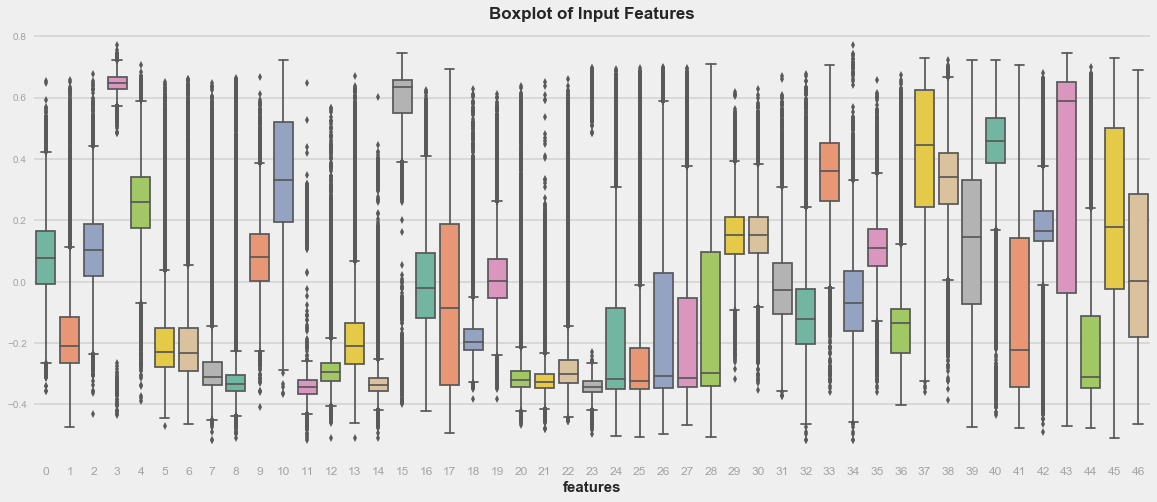

In [7]:
for col in df_X.columns:
    df_X = df_X[np.abs(df_X[col]-df_X[col].mean()) <= (5 * df_X[col].std())] # remove outliers

sr_Y = sr_Y[df_X.index]

print('\nCurrent shape of input data set : {0}'.format(df_X.shape))

def standarize(arr_X):
    arr_X = prep.MinMaxScaler().fit_transform(arr_X)
    return arr_X - arr_X.mean(axis=1).reshape(-1, 1)

arr_X = df_X.values
arr_X = standarize(arr_X)

v = vis.Visual(1, 1, figsize=(20, 8))
vis.sns.boxplot(data=arr_X, orient='v', palette='Set2')

v.axes.set_xlabel('features', **vis.ax_font)
v.axes.set_xticklabels(range(47), fontsize=12)
v.axes.set_title('Boxplot of Input Features', **vis.fig_font)

vis.plt.show()

### Binarize the target feature:

As we mentioned before, we use the median value 1400 as the threshold to binarize target feature and divide the data points into 2 classes. Because of the outlier removal, the sizes of 2 classes are not the same anymore. But they are still more or less balanced.

In [8]:
arr_Y = prep.binarize(sr_Y.values.reshape(-1, 1), threshold=1400) # using original median as threshold
sr_Y = pd.Series(arr_Y.ravel())

unique_items, counts = np.unique(arr_Y, return_counts=True)
print('size of class 0: {0}'.format(counts[0]))
print('size of class 1: {0}'.format(counts[1]))

size of class 0: 18119
size of class 1: 17097


### Split data sets:

Before fit models on the data, I split the data set into training set and test set with sizes 27000 and 8126 repectively.

In [9]:
idx = list(range(len(arr_Y)))
np.random.shuffle(idx)

test_set_idx = idx[:8216]
training_set_idx = idx[8216:]

X_train = arr_X[training_set_idx]; y_train = arr_Y[training_set_idx]
X_test = arr_X[test_set_idx]; y_test = arr_Y[test_set_idx]

y_train.tofile('data/clean_dataset/y_train', format="%d"); y_test.tofile('data/clean_dataset/y_test', format="%d")

# Feature engineering and visuallization

To get a sense of how data points distributed in the feature space, we plot out scatters of some randomly selected feature pairs. 

In the original feature space, data points of 2 classes are heavily blending together. Thus it's quite difficult to separate them by either linear or nonlinear decision boundaries.

So I further decomposite the data set using some dimensionality reduction methods to see whether data points are more separable in reconstructed feature spaces.

### Original feature space:

As we can see, there is no obvious pattern we can deploy to separate the classes using original features. We have to use model of very high capacity to reduce the training error rate. But that would lead to high generation error rate.

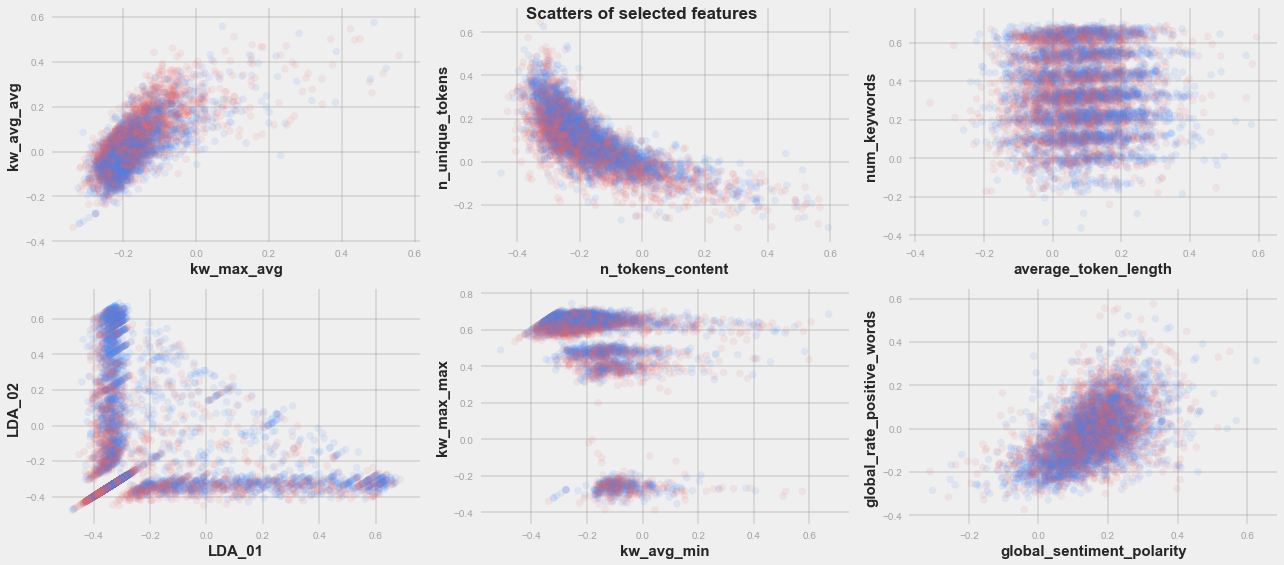

In [10]:
X_train.tofile('data/clean_dataset/x_train_ori')
X_test.tofile('data/clean_dataset/x_test_ori')

X_feats = list(df_X)
plot_feats = [[18,19], [1, 2], [9,10], [25,26], [13,15], [30,31]]

v = vis.Visual(2, 3, figsize=(18, 8))
v.scatters(X_train[:6000], y_train[:6000], plot_feats, X_feats, alpha=0.1)

### PCA:

If we try to decomposite the data set by principle component analysis, can we reconstruct features that separate the classes better? Judging from scatter plot, we can see that, for this data set, finding the linear combinations preseving the maximal amount of variance is not an ideal way to engineer features. 

But how is it compared to the original features? We have to put the transformed data set into the models and compare the performance with what we get in original feature space.

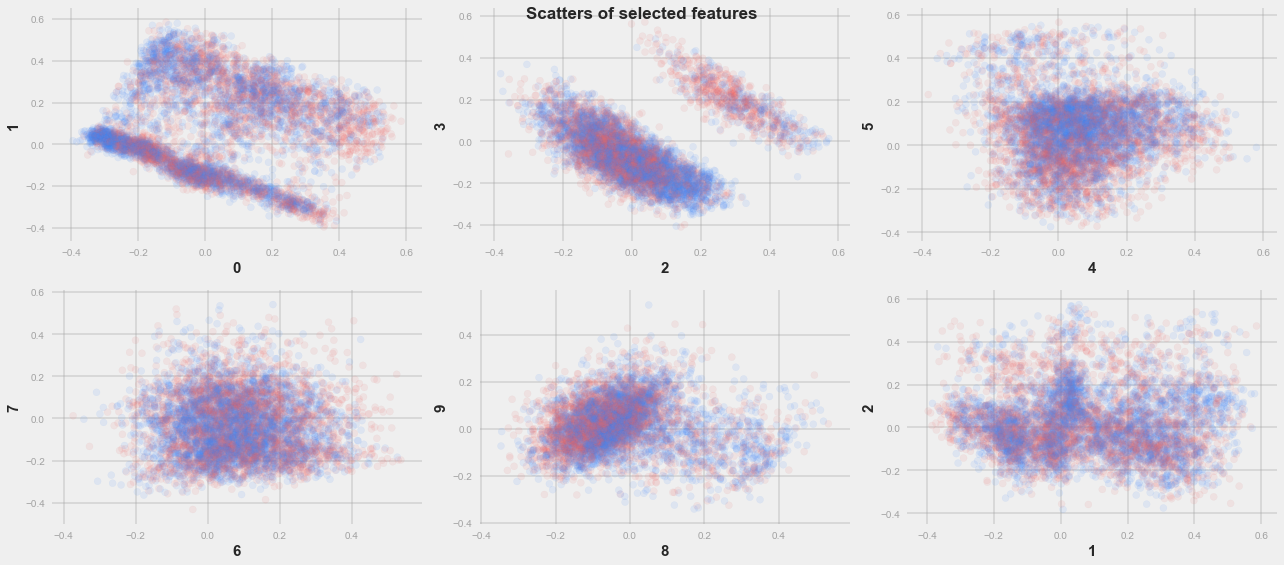

In [11]:
pca = PCA().fit(X_train)

X_train_pca = pca.transform(X_train); X_train_pca = standarize(X_train_pca)
X_test_pca = pca.transform(X_test); X_test_pca = standarize(X_test_pca)

X_train_pca.tofile('data/clean_dataset/x_train_pca')
X_test_pca.tofile('data/clean_dataset/x_test_pca')

plot_feats = [[0,1], [2, 3], [4,5], [6,7], [8,9], [1,2]]

v = vis.Visual(2, 3, figsize=(18, 8))
v.scatters(X_train_pca[:6000], y_train[:6000], plot_feats, list(range(47)), alpha=0.1)

### SparsePCA:

If we set a limitation of the maximum number of features can be linear combined in PCA, we have the sparse PCA.

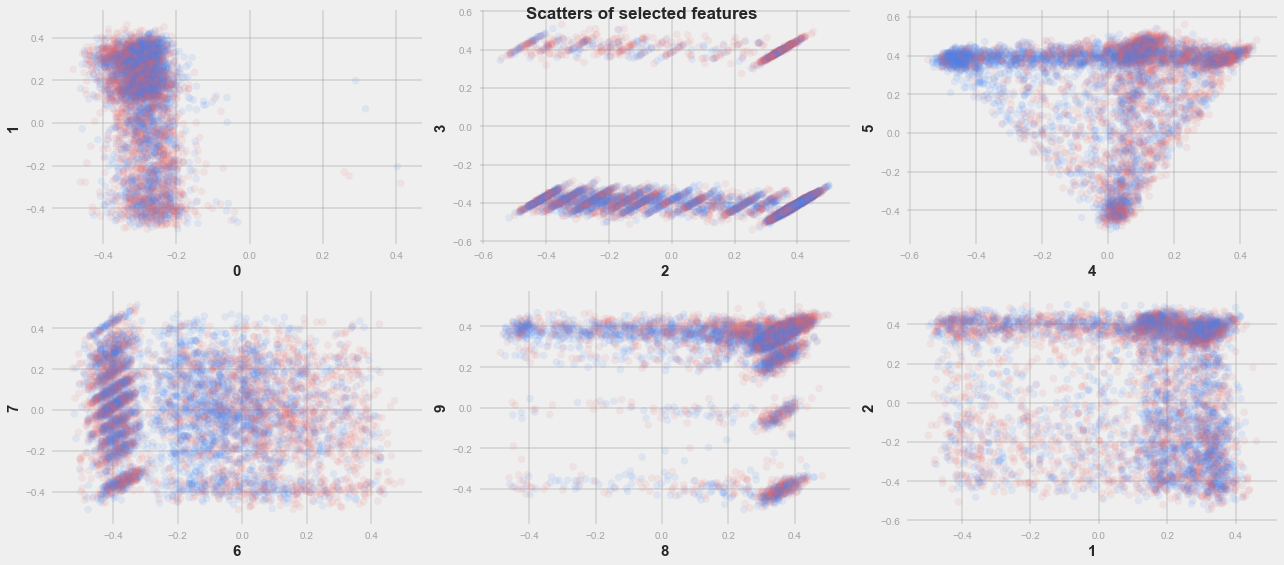

In [12]:
spca = SparsePCA(n_components=30).fit(X_train)

X_train_spca = spca.transform(X_train); X_train_spca = standarize(X_train_spca)
X_test_spca = spca.transform(X_test); X_test_spca = standarize(X_test_spca)

X_train_spca.tofile('data/clean_dataset/x_train_spca')
X_test_spca.tofile('data/clean_dataset/x_test_spca')

plot_feats = [[0,1], [2, 3], [4,5], [6,7], [8,9], [1,2]]

v = vis.Visual(2, 3, figsize=(18, 8))
v.scatters(X_train_spca[:6000], y_train[:6000], plot_feats, list(range(47)), alpha=0.1)

### FactorAnalysis:

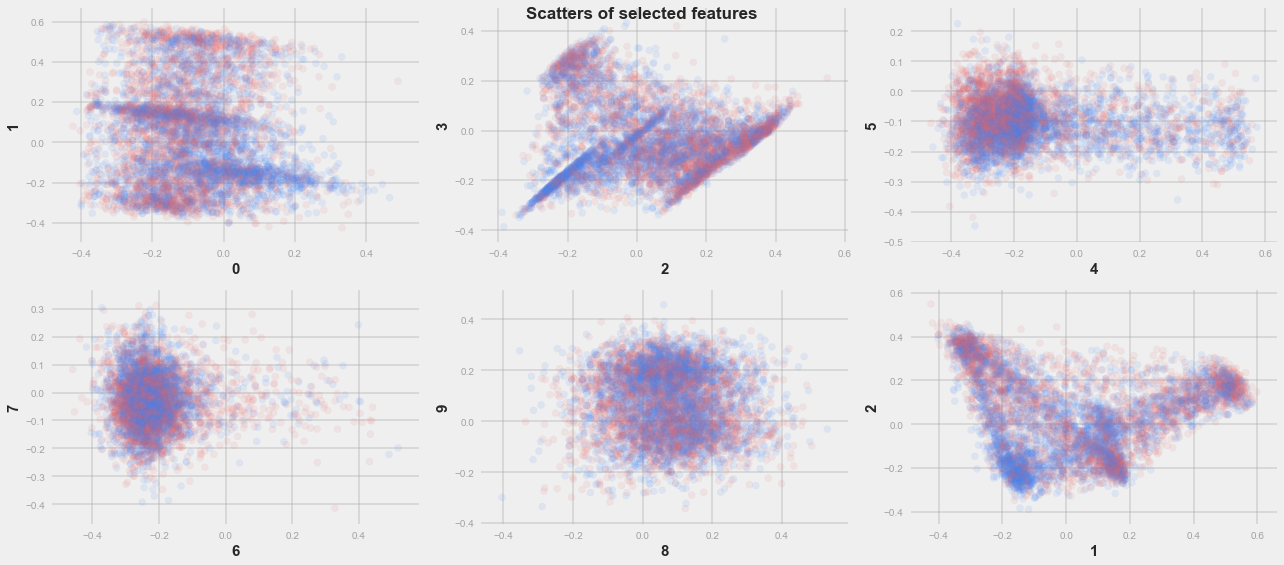

In [13]:
fa = FactorAnalysis(n_components=25).fit(X_train)

X_train_fa = fa.transform(X_train); X_train_fa = standarize(X_train_fa)
X_test_fa = fa.transform(X_test); X_test_fa = standarize(X_test_fa)

X_train_fa.tofile('data/clean_dataset/x_train_fa')
X_test_fa.tofile('data/clean_dataset/x_test_fa')

plot_feats = [[0,1], [2, 3], [4,5], [6,7], [8,9], [1,2]]

v = vis.Visual(2, 3, figsize=(18, 8))
v.scatters(X_train_fa[:6000], y_train[:6000], plot_feats, list(range(47)), alpha=0.1)

### NMF:

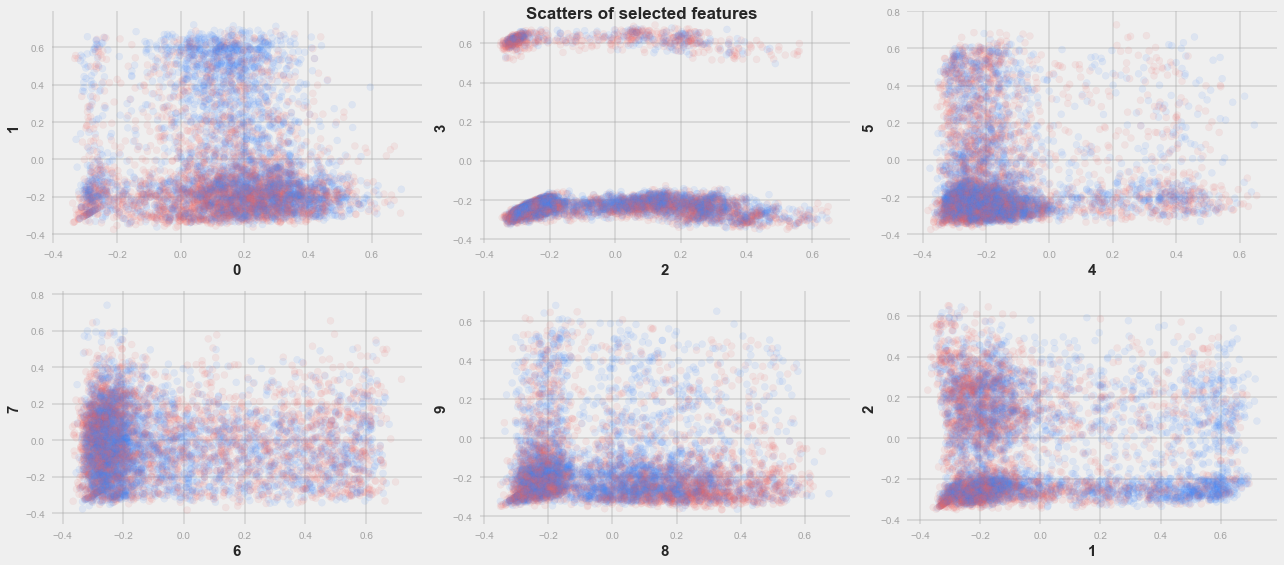

In [14]:
nmf = NMF(n_components=15).fit(X_train - X_train.min(0))

X_train_nmf = nmf.transform(X_train - X_train.min(0)); X_train_nmf = standarize(X_train_nmf)
X_test_nmf = nmf.transform(X_test - X_test.min(0)); X_test_nmf = standarize(X_test_nmf)

X_train_nmf.tofile('data/clean_dataset/x_train_nmf')
X_test_nmf.tofile('data/clean_dataset/x_test_nmf')

plot_feats = [[0,1], [2, 3], [4,5], [6,7], [8,9], [1,2]]

v = vis.Visual(2, 3, figsize=(18, 8))
v.scatters(X_train_nmf[:6000], y_train[:6000], plot_feats, list(range(47)), alpha=0.1)

## Conclusion

Observing the above plottings, none of them shows a trivial way to draw a decision boundary. We will move on to model fitting and selection part to try different classifiers and compare their performances.